#STEPS:

1. Collect the data
2. Preprocess the data (LSTM is sensitive to scaling)
3. Divide into train and test
4. Create a stacked LSTM model
5. Predict the test data and plot the output
6. Predict future 30 days and plot the output

### Collecting the data

In [1]:
import os, time
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from six import BytesIO
import numpy as np
import pandas as pd
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps
import seaborn as sns
import plotly.express as px

In [2]:
import io
from google.colab import files

In [3]:
! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d jainilcoder/netflix-stock-price-prediction

Saving kaggle.json to kaggle.json
  0% 0.00/20.9k [00:00<?, ?B/s]
100% 20.9k/20.9k [00:00<00:00, 15.8MB/s]


In [4]:
! unzip netflix-stock-price-prediction.zip

Archive:  netflix-stock-price-prediction.zip
  inflating: NFLX.csv                


In [5]:
df = pd.read_csv('NFLX.csv')

In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


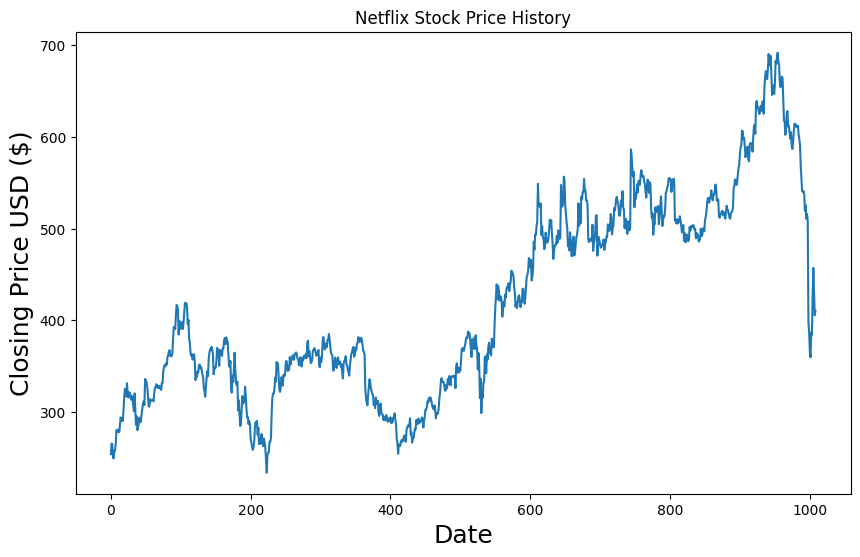

In [10]:
# Plot the data
plt.figure(figsize=(10,6))
plt.title('Netflix Stock Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.show()

In [17]:
df1 = df.reset_index()['Close']

In [20]:
df1.shape, type(df1)

((1009,), pandas.core.series.Series)

### Preprocessing the Data


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

By scaling the data, we can ensure that the LSTM model can effectively learn from the input data, and that the gradients used during training do not become too large or too small. This can help to improve the performance of the model and reduce the risk of overfitting.

In [24]:
df1

array([[0.04451626],
       [0.06954849],
       [0.06701469],
       ...,
       [0.4272515 ],
       [0.37509011],
       [0.38507243]])

if you have a sequence of time-series data with shape (batch_size, timesteps, input_dim), where batch_size is the number of samples in each batch, timesteps is the length of the sequence, and input_dim is the number of features at each time step, you may need to reshape it to (batch_size, timesteps, features) to match the expected input shape of the LSTM layer.

Alternatively, if you have a 2D input with shape (batch_size, features) that you want to process with an LSTM layer, you may need to reshape it to (batch_size, timesteps, features) by adding a time dimension.

In [25]:
df1.shape, type(df1)

((1009, 1), numpy.ndarray)

### Splitting into train and test

In case of time-series data, ordered with respect to date, we should split the dataset according to that order only.

This is because a particular value in time is dependent on all the previous values.

In [80]:
training_size = int(len(df1)*0.60)
test_size = len(df1) - training_size

In [81]:
training_size, test_size

(605, 404)

In [82]:
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [83]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset) - time_step - 1):
    a = dataset[i:(i + time_step),:]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  
  return np.array(dataX), np.array(dataY)

In [84]:
time_step = 100

In [85]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data,time_step)

In [86]:
X_train.shape, y_train.shape

((504, 100, 1), (504,))

In [87]:
X_test.shape, y_test.shape

((303, 100, 1), (303,))

### Create a stacked LSTM model

Stacked LSTM implies that we have multiple LSTM layers, one after the other, in our model.

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [97]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

In [98]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [99]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), 
          epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
8/8 [==============================] - 10s 394ms/step - loss: 0.0193 - val_loss: 0.0326
Epoch 2/100
8/8 [==============================] - 2s 222ms/step - loss: 0.0063 - val_loss: 0.0702
Epoch 3/100
8/8 [==============================] - 2s 217ms/step - loss: 0.0044 - val_loss: 0.0254
Epoch 4/100
8/8 [==============================] - 2s 213ms/step - loss: 0.0039 - val_loss: 0.0435
Epoch 5/100
8/8 [==============================] - 2s 220ms/step - loss: 0.0034 - val_loss: 0.0163
Epoch 6/100
8/8 [==============================] - 3s 365ms/step - loss: 0.0029 - val_loss: 0.0143
Epoch 7/100
8/8 [==============================] - 2s 217ms/step - loss: 0.0027 - val_loss: 0.0077
Epoch 8/100
8/8 [==============================] - 2s 219ms/step - loss: 0.0025 - val_loss: 0.0061
Epoch 9/100
8/8 [==============================] - 2s 216ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 10/100
8/8 [==============================] - 2s 214ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 11

### Predict the test data and plot the output

In [101]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

10/10 [==============================] - 1s 99ms/step


Now we will perform inverse scaling because we also want to find out the RMSE matrix

In [102]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [103]:
train_predict.shape, test_predict.shape

((504, 1), (303, 1))

Calculating RMSE Performane Metric:

In [104]:
import math
from sklearn.metrics import mean_squared_error

In [105]:
math.sqrt(mean_squared_error(y_train, train_predict))

347.1362841074369

In [106]:
math.sqrt(mean_squared_error(y_test, test_predict))

560.8681527571641

#### Plotting the output

<function matplotlib.pyplot.show(close=None, block=None)>

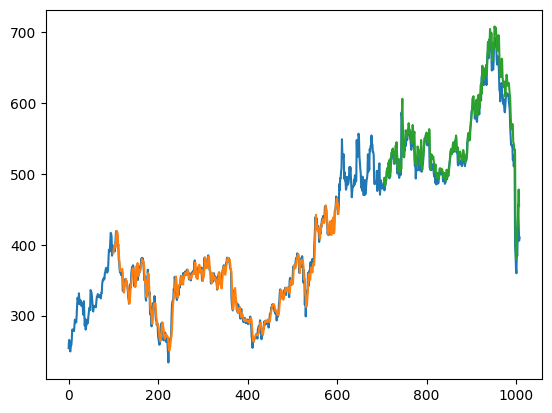

In [108]:
look_back = 100

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2) + 1: len(df1) - 1, :] = test_predict

# Plotting Baseline and Predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show

Here:

1. Green : Predicted Output
2. Orange : Training prediction
3. Blue : The actual dataset

### Predict future 30 days and plot the output

In [109]:
len(test_data)

404

In [110]:
len(test_data) - 100

304

Therefore, 304 to 404 are my previous hundred days for the first output of forecasting

In [111]:
x_input = test_data[304:].reshape(1,-1)
x_input.shape

(1, 100)

In [112]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [114]:
type(temp_input)

list

In [115]:
len(temp_input)

100

In [116]:
temp_input

[0.7623031220089325,
 0.770232186519946,
 0.7764574241046989,
 0.7460518342503559,
 0.741049807175792,
 0.779297134920363,
 0.7849981594001756,
 0.7830978186350088,
 0.7836438967059076,
 0.7644437065449226,
 0.797667144433283,
 0.8223062503372986,
 0.8284441613012656,
 0.8070377960750383,
 0.8757563085718285,
 0.8851269602135838,
 0.8692906961575151,
 0.8710599825542908,
 0.8587841584420446,
 0.8541971550699885,
 0.8647255577514177,
 0.8735501313222742,
 0.8615145487965392,
 0.8826586764115594,
 0.884908581408719,
 0.854634045922767,
 0.9158383843680022,
 0.9412202154248719,
 0.9562481616145222,
 0.9493895237067091,
 0.9371572940990189,
 0.9614687007370002,
 0.9969856403113886,
 0.9770209932746399,
 0.9694850896844873,
 0.9925732858122798,
 0.9491274149699269,
 0.8995870966094257,
 0.9121032955512327,
 0.9220200252638868,
 0.9021864325955293,
 0.9254931407712357,
 0.9801664073316425,
 0.9730019329394415,
 0.9906293483582447,
 1.0,
 0.9788777395352508,
 0.9718441840840797,
 0.9290317157

In [117]:
# demonstrate prediction for next 10 days
from numpy import array

In [118]:
lst_output=[]
n_steps=100
i=0

In [119]:
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.34575257]
101
1 day input [0.77023219 0.77645742 0.74605183 0.74104981 0.77929713 0.78499816
 0.78309782 0.7836439  0.76444371 0.79766714 0.82230625 0.82844416
 0.8070378  0.87575631 0.88512696 0.8692907  0.87105998 0.85878416
 0.85419716 0.86472556 0.87355013 0.86151455 0.88265868 0.88490858
 0.85463405 0.91583838 0.94122022 0.95624816 0.94938952 0.93715729
 0.9614687  0.99698564 0.97702099 0.96948509 0.99257329 0.94912741
 0.8995871  0.9121033  0.92202003 0.90218643 0.92549314 0.98016641
 0.97300193 0.99062935 1.         0.97887774 0.97184418 0.92903172
 0.91780432 0.92704392 0.94309869 0.93916696 0.89124314 0.83853568
 0.83569596 0.804373   0.82743933 0.85559515 0.86105593 0.82374784
 0.82518942 0.80968086 0.79532991 0.81072929 0.78019265 0.77073453
 0.78604659 0.81046718 0.83082499 0.83049742 0.82837857 0.82311443
 0.82274301 0.8261288  0.80505013 0.79397565 0.78038929 0.72877398
 0.69769113 0.67097703 0.66833397 0.67049655 0.66258921 0.623228
 0.63740416 0.60487972 0.61593233 0

In [120]:
print(lst_output)

[[0.3457525670528412], [0.33218520879745483], [0.32829365134239197], [0.33363914489746094], [0.3458097279071808], [0.36134234070777893], [0.3768843412399292], [0.3897210657596588], [0.3980581760406494], [0.4011712968349457], [0.39940664172172546], [0.394000381231308], [0.38672712445259094], [0.37945234775543213], [0.37371310591697693], [0.37043583393096924], [0.3698481023311615], [0.37156590819358826], [0.374792218208313], [0.37855345010757446], [0.3819196820259094], [0.3841729760169983], [0.3849104642868042], [0.3840738534927368], [0.3819110095500946], [0.37888187170028687], [0.3755335807800293], [0.37237629294395447], [0.3697844445705414], [0.36794427037239075]]


In [121]:
# day_new is to store data about the previous 100 days
day_new=np.arange(1,101)

# day_pred is to store the data about the predicted 30 days
day_pred=np.arange(101,131)

In [122]:
len(df1)

1009

In [123]:
len(df1) - 100

909

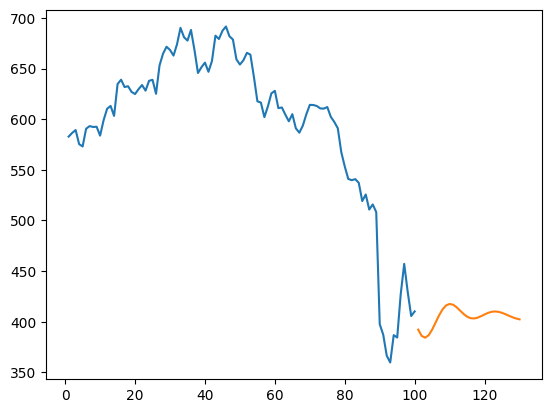

In [124]:
plt.plot(day_new,scaler.inverse_transform(df1[909:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

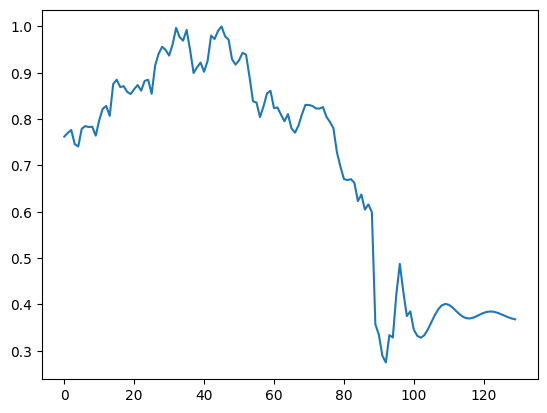

In [127]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[909:])